## Import dependencies

In [3]:
import json
import os

from timeit import default_timer as timer
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import carball
import carball.json_parser.game as game_module
Game = game_module.Game

# pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)
# pd.set_option('display.width', 1000)

In [4]:
print(tf.__version__)
print(tf.test.is_gpu_available()) # tells if the gpu is available
print(tf.test.gpu_device_name()) # returns the name of the gpu device

2.0.1
True
/device:GPU:0


In [5]:
# replay_path = './parsed_replays/rlcs_season_7/'
replay_path = './parsed_replays/'
!ls parsed_replays/

1v1_ai_sample_01.json  1v1_ai_sample_02.json


In [6]:
game_files = []
path = './replays/rlcs_season_7/'
for filename in os.listdir(replay_path):
  if filename.endswith('.json'):
    game_files.append(replay_path + filename)
# game_files = game_files[0:8] # TEST - use subset of games for now
print(len(game_files))
print(list(game_files))

2
['./parsed_replays/1v1_ai_sample_01.json', './parsed_replays/1v1_ai_sample_02.json']


In [7]:
def get_game(file_path):
  game = game_module.Game()
  game.initialize(file_path=file_path)
  return game

if len(game_files) > 0:
  game = game_module.Game()
  game.initialize(
      file_path=game_files[0])
else:
  raise IndexError('No game_files to parse.')

Could not find field_of_view in camera settings for Casper
Could not find height in camera settings for Casper
Could not find pitch in camera settings for Casper
Could not find distance in camera settings for Casper
Could not find stiffness in camera settings for Casper
Could not find swivel_speed in camera settings for Casper
Could not find transition_speed in camera settings for Casper


In [8]:
game.map

'Stadium_P'

In [9]:
game.players

[Player: Paragon.RG on Team: Orange, Player: Casper on Team: Blue]

In [10]:
print(game.ball.shape)
game.ball.head(3)

(9372, 13)


,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,vel_x,vel_y,vel_z,ang_vel_x,ang_vel_y,ang_vel_z,hit_team_no
1,0.0,0.0,92.74,0.000005,0.000005,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,92.74,0.000005,0.000005,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,92.74,0.000005,0.000005,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
game.players[0].name

'Paragon.RG'

In [12]:
game.__dict__.keys()

dict_keys(['file_path', 'properties', 'replay_id', 'map', 'name', 'id', 'datetime', 'replay_version', 'teams', 'players', 'goals', 'primary_player', 'frames', 'kickoff_frames', 'ball', 'ball_type', 'demos', 'parties', 'dropshot', 'match_type', 'team_size', 'game_info'])

In [13]:
game.properties.keys()
# game.game_info.__dict__.keys()

dict_keys(['MaxChannels', 'GameVersion', 'BuildVersion', 'Team1Score', 'PlayerName', 'KeyframeDelay', 'ReserveMegabytes', 'PlayerStats', 'MaxReplaySizeMB', 'NumFrames', 'MatchType', 'MapName', 'BuildID', 'Goals', 'ReplayVersion', 'Changelist', 'Date', 'ReplayName', 'UnfairTeamSize', 'PrimaryPlayerTeam', 'ReplayLastSaveVersion', 'Id', 'Team0Score', 'TeamSize', 'RecordFPS', 'HighLights'])

In [14]:
player_0_data = game.players[0].data
print(player_0_data.shape)
player_0_data.head(10)
start = 0
data = player_0_data.iloc[start:start + 10]

(9372, 23)


In [15]:
def equalize_player_data_rows(game):
  '''
  Updates the game data to ensure all player data lines up.
  Modifies the game object in place.
  '''
  # @TODO Update this for efficiency using the following:
    # https://stackoverflow.com/questions/48864923/pythonpandas-select-certain-rows-by-index-of-another-dataframe

  # @TODO Merge ball data as well!

  player1 = game.players[0]
  other_players = game.players[1:]
  columns = player1.data.columns
  ball_columns = game.ball.columns
  changed_ball_columns = list(map(lambda x: x + '_ball', ball_columns))
  merged_player_data = player1.data

  game.ball.columns = changed_ball_columns

  for i, player in enumerate(other_players):
    suffix = f'_p{i + 2}'
    merged_player_data = merged_player_data.merge(player.data, left_index=True, right_index=True, suffixes=('', suffix))
  merged_player_data = merged_player_data.merge(game.ball, left_index=True, right_index=True)

  game.ball = merged_player_data[changed_ball_columns]
  game.ball.columns = ball_columns

  game.players[0].data = merged_player_data[columns]
  for i, player in enumerate(game.players[1:]):
    suffixed_columns = list(map(lambda x: x + f'_p{i + 2}', columns))
    game.players[i + 1].data = merged_player_data[suffixed_columns]
    game.players[i + 1].data.columns = columns

In [16]:
game.ball.describe()

,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,vel_x,vel_y,vel_z,ang_vel_x,ang_vel_y,ang_vel_z,hit_team_no
count,9372.000000,9372.000000,9372.000000,9372.000000,9372.000000,9372.000000,6955.000000,6955.000000,6955.000000,6955.000000,6955.000000,6955.000000,7263.000000
mean,-270.808818,-1390.726677,292.742621,0.032008,0.062030,0.060736,-63.387405,-2009.761783,83.307822,407.637024,428.501179,-364.727534,0.686906
std,1970.284315,2725.204078,321.166652,0.605156,1.564784,1.524260,8971.477166,9144.856339,4629.723324,3219.635141,3057.800402,2829.859400,0.463784
min,-4009.900000,-5215.160000,88.530000,-1.504617,-3.141223,-3.139310,-31105.500000,-32266.900000,-20042.300000,-5925.600000,-5913.200000,-5940.600000,0.000000
25%,-1704.890000,-3950.967500,93.140000,-0.325619,-0.883463,-0.873229,-5462.100000,-8212.450000,-1544.950000,-1945.200000,-1669.700000,-2583.400000,0.000000
50%,0.000000,-909.625000,155.725000,0.000005,0.000005,0.000005,0.000000,-1260.300000,0.000000,446.700000,146.600000,0.000000,1.000000
75%,617.980000,0.000000,335.602500,0.392106,1.094436,1.041990,6196.550000,3162.600000,1723.800000,2929.700000,3004.000000,1927.100000,1.000000
max,4002.710000,5214.100000,1969.920000,1.554465,3.139370,3.139530,19626.800000,31230.000000,24308.300000,5998.400000,5995.600000,5976.100000,1.000000


In [17]:
def get_game_state_columns():
    return [ # built-in columns only - no added data
        'pos_x',
        'pos_y',
        'pos_z',
        'rot_x',
        'rot_y',
        'rot_z',
        'vel_x',
        'vel_y',
        'vel_z',
        'ang_vel_x',
        'ang_vel_y',
        'ang_vel_z',
        'active',
        'boost',
    ]

def get_controller_input_columns():
    return [
        'throttle',
        'steer',
        'handbrake',
        'dodge_active',
        'double_jump_active',
        'jump_active',
        'boost_active',
    ]

def get_ball_columns():
    return [
        'pos_x',
        'pos_y',
        'pos_z',
        'vel_x',
        'vel_y',
        'vel_z',
    ]

In [18]:
def add_active_column(df):
    '''Returns a new dataframe with an extra 'action' column.
    '''
    dataframe = df.assign(active=(~np.isnan(df['steer'])).astype(int))
    return dataframe

In [19]:
def squeeze_value(value, fudge_factor=0.10):
  '''Squeezes 0-1 values between, say, 0.05-0.95 for sigmoid activations.
  '''
  return value # hack - do not squeeze value if not using sigmoid activations.
  return value * (1 - fudge_factor) + (fudge_factor / 2)

def normalize_data(dataframe, fudge_factor=0.10):
  '''
  Returns a normalized copy of a dataframe.
  Fudges the data to place it between (say) 0.025-0.975 instead of 0-1.
  The dataframe provided should contain only numerical data.
  Provides simple min-max normalization.
  '''
  normalized = (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min())
  # return normalized * (1 - fudge_factor) + (fudge_factor / 2)
  return squeeze_value(normalized, fudge_factor)

def normalize_player_data(player_df, main_player=False):
  '''
  Returns a normalized dataframe of player data. Normalizes only numerical data.
  '''
  cols_to_normalize = player_df.select_dtypes(include=np.number).columns.tolist()
  cols = player_df[cols_to_normalize]
  return normalize_data(cols)

In [20]:
def clean_player_data(player_df, main_player=False, team=None):
    '''Handles cleaning, copying, etc. of a player dataframe.
    '''
    with_active = add_active_column(player_df)
    str_bool_to_int = { 'True': 1, 'False': 0, np.nan: 0, None: 0 }
    
    # convert odd-number based activations to 0 and 1
    def odd_num_to_bool(num):
      # if np.isnan(num): return 0
      return int(num % 2 == 1)
    with_active['dodge_active'] = with_active['dodge_active'].apply(odd_num_to_bool)
    with_active['jump_active'] = with_active['jump_active'].apply(odd_num_to_bool)
    with_active['double_jump_active'] = with_active['double_jump_active'].apply(odd_num_to_bool)

    dtypes_map = dict(with_active.dtypes)
    if dtypes_map['ball_cam'] == np.bool:
      with_active['ball_cam'] = with_active['ball_cam'].astype(int)
    elif dtypes_map['ball_cam'] == np.str:
      with_active['ball_cam'] = with_active.replace({ 'ball_cam': str_bool_to_int })

    cleaned = with_active.replace({
        'handbrake': str_bool_to_int,
        # 'ball_cam': str_bool_to_int,
        # 'boost_active': str_bool_to_int
        # 'double_jump_active': str_bool_to_int,
    })

    cleaned = cleaned.fillna(0)

    if not main_player:
        cleaned = cleaned[get_game_state_columns()]

    return cleaned

In [21]:
def clean_ball_data(ball):
  ball = ball[get_ball_columns()].copy()
  ball = ball.fillna(0)
  return ball

In [22]:
def get_stadium_number(stadium):
  stadiums = [
    'cs_day_p',
    'NeoTokyo_Standard_P',
    'UtopiaStadium_Dusk_P',
    'Stadium_P',
    'EuroStadium_Night_P',
    'TrainStation_Dawn_P',
    'cs_p',
    'EuroStadium_P',
    'Underwater_P',
    'arc_standard_p',
    'stadium_day_p',
    'wasteland_Night_S_P',
    'beach_P',
    'wasteland_s_p',
    'beach_night_p',
    'Farm_Night_P',
    'Farm_UpsideDown_P',
    'EuroStadium_Rainy_P',
    'UtopiaStadium_P',
  ]

  try:
    index = stadiums.index(stadium)
  except ValueError:
    print(f"WARNING: Stadium {stadium} does not have a numeric mapping.")
    return 0
  return (index + 1) / (len(stadiums) + 1)

In [23]:
# This cell is modified from David Wolever's answer here: https://stackoverflow.com/a/13849249
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.sum(np.multiply(v1_u, v2_u), axis=1), -1.0, 1.0))

In [24]:
df = pd.DataFrame({
    'x': [1, 2, 3, 4, 5],
    'y': [4, 5, 6, 7, 8],
    'z': [7, 8, 9, 10, 11],
})
df2 = pd.DataFrame({
    'x': [2, 3, 4, 5, 6],
    'y': [5, 7, 9, 11, 13],
    'z': [7, 8, 9, 10, 11],
})

diff = df.subtract(df2, axis=0)
print(diff)
print(np.linalg.norm(diff.values, axis=1))
# player_relative['ball_dist'] = np.linalg.norm(player_position - ball_position)

df.set_axis(('a', 'b', 'c'), axis=1, inplace=False)

   x  y  z
0 -1 -1  0
1 -1 -2  0
2 -1 -3  0
3 -1 -4  0
4 -1 -5  0
[1.41421356 2.23606798 3.16227766 4.12310563 5.09901951]


,a,b,c
0,1,4,7
1,2,5,8
2,3,6,9
3,4,7,10
4,5,8,11


In [25]:
name = 'asdf'
name[-1:]

'f'

In [26]:
def get_relative_data(player, ball, opponent):
  '''
  Returns a new set of dataframes with data relative to the player.
  '''
  print(f"Player shape (in get_relative_data): {player.shape}")
  print(f"Opponent shape (in get_relative_data): {opponent.shape}")
  print(f"Ball shape (in get_relative_data): {ball.shape}")
  # NOTE: should eventually handle a list of teammates and opponents
  columns = get_game_state_columns()
  ball_columns = get_ball_columns()

  player_relative = pd.DataFrame()
  opponent_relative = pd.DataFrame()
  ball_relative = pd.DataFrame()

  player_relative['boost'] = player['boost']
  player_relative['active'] = player['active']
  player_relative['vel_x'] = player['vel_x']
  player_relative['vel_y'] = player['vel_y']
  player_relative['vel_z'] = player['vel_z']
  # player_relative['ang_vel_x'] = player['ang_vel_x']
  # player_relative['ang_vel_y'] = player['ang_vel_y']
  # player_relative['ang_vel_z'] = player['ang_vel_z']
  player_relative['jump_active'] = player['jump_active']
  # player_relative['double_jump_active'] = player['double_jump_active'] # seems to be empty and causes NaNs
  player_relative['dodge_active'] = player['dodge_active']

  column_names = ('x', 'y', 'z')
  player_position = player[['pos_x', 'pos_y', 'pos_z']].set_axis(column_names, axis=1, inplace=False)
  player_facing = player[['rot_x', 'rot_y', 'rot_z']].set_axis(column_names, axis=1, inplace=False)
  player_vel = player[['vel_x', 'vel_y', 'vel_z']].set_axis(column_names, axis=1, inplace=False)
  player_spinning = player[['ang_vel_x', 'ang_vel_y', 'ang_vel_z']].set_axis(column_names, axis=1, inplace=False)
  ball_position = ball[['pos_x', 'pos_y', 'pos_z']].set_axis(column_names, axis=1, inplace=False)
  ball_vel = ball[['vel_x', 'vel_y', 'vel_z']].set_axis(column_names, axis=1, inplace=False)

  goal_height = 642.775
  back_wall = 5120
  # Floor: 0
  # Center field: (0, 0)
  # Side wall: 4096
  # Back wall: 5120
  # Ceiling: 2044
  # Goal height: 642.775
  # Goal center-to-post: 892.755

  player_relative['ball_dist'] = np.linalg.norm(player_position - ball_position, axis=1)
  player_relative['angle_to_face_ball'] = angle_between(player_facing, ball_position)
  player_relative['angle_to_move_to_ball'] = angle_between(player_vel, ball_position)

  player_relative['opposing_goal_x'] = -player_position['x']
  # @TODO This needs to be based on the player's 'team' - could have +/- y
  player_relative['opposing_goal_y'] = -back_wall - player_position['y']
  player_relative['opposing_goal_z'] = (goal_height / 2) - player_position['z']

  ball_relative['vel_x'] = ball_vel['x'] - player_vel['x']
  ball_relative['vel_y'] = ball_vel['y'] - player_vel['y']
  ball_relative['vel_z'] = ball_vel['z'] - player_vel['z']
  ball_relative['pos_z'] = ball_position['z']

  opponent_relative['pos_x'] = opponent['pos_x'] - player['pos_x']
  opponent_relative['pos_y'] = opponent['pos_y'] - player['pos_y']
  opponent_relative['pos_z'] = opponent['pos_z'] - player['pos_z']
  opponent_relative['vel_x'] = opponent['vel_x'] - player['vel_x']
  opponent_relative['vel_y'] = opponent['vel_y'] - player['vel_y']
  opponent_relative['vel_z'] = opponent['vel_z'] - player['vel_z']

  # @TODO Drop player columns that are now represented by other means
    # Eg. player position should now be represented by distance to walls and
    # distance & angle to net.
  return player_relative, ball_relative, opponent_relative

In [27]:
def get_X_and_y(player, team, opponents, ball, game, team_num):
    '''
    Returns X (input) and y (labels) for a neural network. Accepts arguments
    relating to the data from a replay.
    '''
    player = clean_player_data(player.data, main_player=True)
    # player = player[player['active'] == 1] # take only rows where player is active. NOTE: This was causing mis-alignment in relative data.
    # teammate1 = clean_player_data(team[0].data)
    # teammate2 = clean_player_data(team[1].data)
    opponent1 = clean_player_data(opponents[0].data)
    # opponent2 = clean_player_data(opponents[1].data)
    # opponent3 = clean_player_data(opponents[2].data)
    ball = clean_ball_data(ball)

    y = player[get_controller_input_columns()]

    # @TODO Update player dataframes to be relative to player with ball cam
    player, ball, opponent1 = get_relative_data(player, ball, opponent1)
    
    # @TODO Flip x/y values of opponents: pos_y, rot_y, vel_y, ang_vel_y
    # This ensures all training happens in the same direction (eg. opponent's goal is positive)
    # OR, simply assign each player a Team input set to 0 or 1.
    # NOTE: Need to think about what is required for this to make sense. Will try without.

    player = normalize_player_data(player, main_player=True)

    X = player#[get_game_state_columns()]

    # Normalize remainder of data
    opponent1 = normalize_player_data(opponent1)
    ball = normalize_data(ball)
    y = normalize_data(y, fudge_factor=0) # do not fudge predictions!

    # X = pd.merge(X, teammate1, left_index=True, right_index=True, suffixes=('', '_team1'))
    # X = pd.merge(X, teammate2, left_index=True, right_index=True, suffixes=('', '_team2'))
    X = pd.merge(X, opponent1, left_index=True, right_index=True, suffixes=('', '_op1'))
    # X = pd.merge(X, opponent2, left_index=True, right_index=True, suffixes=('', '_op2'))
    # X = pd.merge(X, opponent3, left_index=True, right_index=True, suffixes=('', '_op3'))
    X = pd.merge(X, ball, left_index=True, right_index=True, suffixes=('', '_ball'))

    assert X.shape[0] == y.shape[0], f"X has {X.shape[0]} rows, but y has {y.shape[0]}."
    
    # add any extra fields (must normalize these separately)
    X['map'] = squeeze_value(get_stadium_number(game.map))
    X['team'] = squeeze_value(team_num)

    # @TODO [OPTIONAL] Loop over opponent dataframes. Build up new frames based on closest-to-ball
    return X, y

In [28]:
games = map(get_game, game_files)
print(len(game_files))

2


In [29]:
def get_y_pred_columns():
  return ['steer', 'throttle']

In [30]:
games = map(get_game, game_files)
max_games = -1

def assert_colour(player):
    '''
    Asserts that a blue player has a negative y starting value. This ensures
    that there is consistency between teams and team numbers across replays.
    '''
    player_start = player.data['pos_y'].iloc[0]
    player_colour = 'orange' if player_start > 0 else 'blue'
    # print(player_start > 0, player.is_orange)
    # print(f"Player is {player_colour} and has start of {player_start}.")
    assert (player_start > 0) == player.is_orange, f"Player is {player_colour} but has start of {player_start}."

def get_game_data(game):
  equalize_player_data_rows(game)
  Xs = []
  ys = []
  for i, team in enumerate(game.teams):
      if i > 0: break # hack to skip second team
      team_num = int(team.is_orange)
      team = list(team.players)
      opponents = list(game.teams[1 - i].players)
      for j, player in enumerate(team):
          assert_colour(player)
          if j > 0: continue # hack to skip other players
          teammates = []
          if len(team) == 2:
            teammates = [team[(j + 1) % 3]]
          elif len(team) == 3:
            teammates = [team[(j + 1) % 3], team[(j + 2) % 3]]

  #         print('Me:', player)
  #         print('Teammates:', teammates[0].name, 'and', teammates[1].name)
  #         print('Opponents:', opponents[0].name, opponents[1].name, opponents[2].name)
  #         print('---')
          new_X, new_y = get_X_and_y(player, teammates, opponents, game.ball, game, team_num)
          Xs.append(new_X)
          ys.append(new_y)
  X = pd.concat(Xs)
  y = pd.concat(ys)
  return X, y


num_games = len(game_files) if max_games < 0 else max_games
print(f'Parsing and concatenating {num_games} game(s). -----')

all_Xs = []
all_ys = []
for i, game in enumerate(games):
  if max_games >= 1 and i >= max_games:
    print(f'Stopping at {max_games} max games.')
    break
  # try:
  new_X, new_y = get_game_data(game)
  # except TypeError:
  #   print(f'ERROR: Game invalid. Skipping. ({game})')
  #   continue
  all_Xs.append(new_X)
  all_ys.append(new_y)
  # X = pd.concat(X, new_X)
  # y = pd.concat(y, new_y)
if len(all_Xs) == 0:
  raise ValueError('all_Xs is empty. Should have at least one data set.')
elif len(all_Xs) == 1:
  X = all_Xs[0]
  y = all_ys[0]
else:
  X = pd.concat(all_Xs)
  y = pd.concat(all_ys)

y = y[get_y_pred_columns()]
# throttle, steer, handbrake, dodge_active, double_jump_active, jump_active, boost_active

print(f'Completed game intake. -----')

Parsing and concatenating 2 game(s). -----


Could not find field_of_view in camera settings for Casper
Could not find height in camera settings for Casper
Could not find pitch in camera settings for Casper
Could not find distance in camera settings for Casper
Could not find stiffness in camera settings for Casper
Could not find swivel_speed in camera settings for Casper
Could not find transition_speed in camera settings for Casper


Player shape (in get_relative_data): (9371, 24)
Opponent shape (in get_relative_data): (9371, 14)
Ball shape (in get_relative_data): (9371, 6)


Replay name not found
Could not find field_of_view in camera settings for Swabbie
Could not find height in camera settings for Swabbie
Could not find pitch in camera settings for Swabbie
Could not find distance in camera settings for Swabbie
Could not find stiffness in camera settings for Swabbie
Could not find swivel_speed in camera settings for Swabbie
Could not find transition_speed in camera settings for Swabbie


Player shape (in get_relative_data): (9281, 24)
Opponent shape (in get_relative_data): (9281, 14)
Ball shape (in get_relative_data): (9281, 6)
Completed game intake. -----


In [31]:
start = 300
X.iloc[start:start + 20]
X.describe()

,boost,active,vel_x,vel_y,vel_z,jump_active,dodge_active,ball_dist,angle_to_face_ball,angle_to_move_to_ball,opposing_goal_x,opposing_goal_y,opposing_goal_z,pos_x,pos_y,pos_z,vel_x_op1,vel_y_op1,vel_z_op1,vel_x_ball,vel_y_ball,vel_z_ball,pos_z_ball,map,team
count,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,18652.000000,1.865200e+04,18652.0
mean,0.151920,0.990189,0.523878,0.516021,0.360946,0.007935,0.039406,0.300143,0.481213,0.481540,0.495030,0.608573,0.972444,0.588980,0.437949,0.342710,0.490429,0.522003,0.463163,0.501246,0.646612,0.483289,0.119038,2.000000e-01,0.0
std,0.239403,0.098567,0.153468,0.229959,0.067850,0.088726,0.194564,0.191260,0.162477,0.168391,0.201579,0.265441,0.096544,0.147502,0.221477,0.188218,0.149484,0.141316,0.085747,0.131429,0.127004,0.107070,0.189658,2.775632e-17,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e-01,0.0
25%,0.000000,1.000000,0.452978,0.358039,0.319355,0.000000,0.000000,0.137496,0.391615,0.391337,0.384018,0.422132,0.997645,0.522657,0.287005,0.153261,0.417453,0.472668,0.404386,0.438375,0.560535,0.448528,0.002937,2.000000e-01,0.0
50%,0.015686,1.000000,0.521373,0.500033,0.365944,0.000000,0.000000,0.277336,0.493328,0.466024,0.500513,0.676712,0.997659,0.588853,0.389784,0.434926,0.491712,0.535823,0.464937,0.503584,0.677452,0.480805,0.030810,2.000000e-01,0.0
75%,0.300687,1.000000,0.601360,0.681614,0.395508,0.000000,0.000000,0.430158,0.541933,0.531253,0.598800,0.832034,0.998604,0.660169,0.512875,0.492114,0.569518,0.596559,0.514970,0.569829,0.722344,0.516913,0.153097,2.000000e-01,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000e-01,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6f4108eb8>,
      dtype=object)

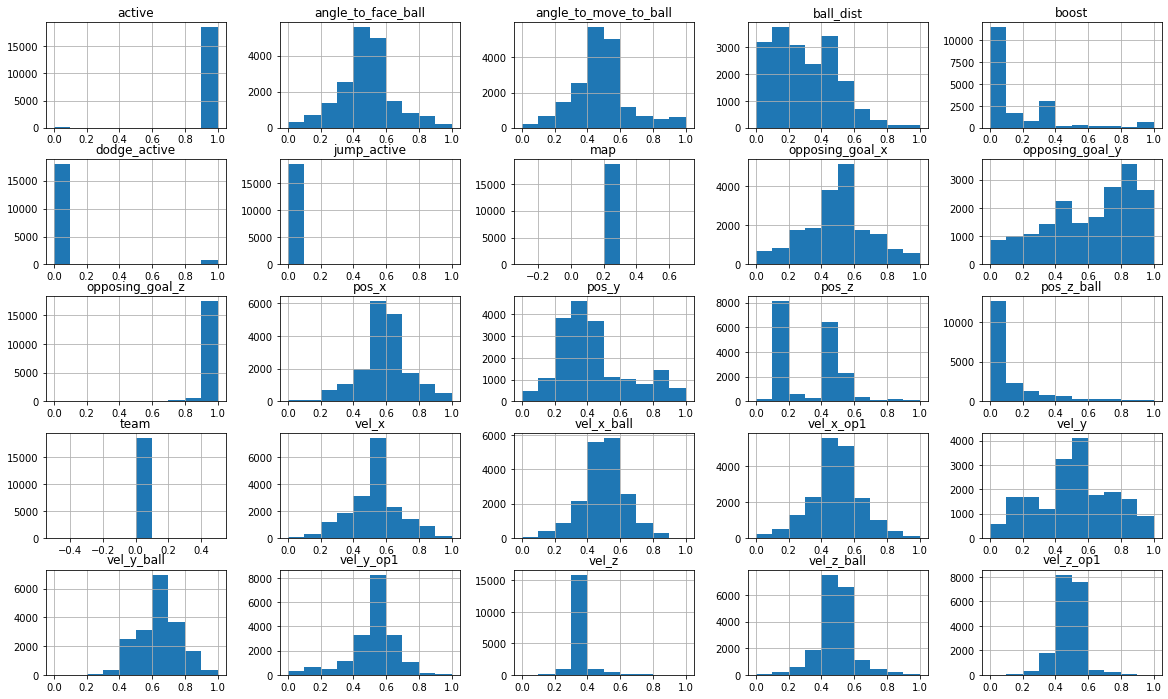

In [32]:
X.hist(figsize=(20, 12))

In [33]:
def take_sample(X, y, quantity):
  if quantity == None: return X, y
  return X[0:quantity], y[0:quantity]


# def split_data(dataframe, shuffle=True, max_val_size=20000, max_test_size=20000):
#   '''
#   Returns the data split into train, val, and test sets.
#   '''
#   if shuffle:
#     dataframe = dataframe.sample(frac=1)
#   m = shuffled.shape[0]
#   size_val_set = min(int(m * 0.2), max_val_size)
#   size_test_set = min(int(m * 0.2), max_test_size)
#   end_test_set = size_val_set + size_test_set

#   val_set = dataframe[0:size_val_set]
#   test_set = dataframe[size_val_set:end_test_set]
#   train_set = dataframe[end_test_set:]
#   return train_set, val_set, test_set

# X_train, X_val, X_test = split_data(X, shuffle=False)

X_shuffled = X#.sample(frac=1)
y_shuffled = y#.sample(frac=1)
assert X_shuffled.shape[0] == y_shuffled.shape[0], f"X has {X_shuffled.shape[0]} rows, but y has {y_shuffled.shape[0]}."
# X_shuffled, y_shuffled = take_sample(X_shuffled, y_shuffled, 3000)
m = X_shuffled.shape[0]

size_val_set = min(int(m * 0.2), 20000)
size_test_set = min(int(m * 0.2), 20000)
end_test_set = size_val_set + size_test_set
X_val = X_shuffled[0:size_val_set]
y_val = y_shuffled[0:size_val_set]
X_test = X_shuffled[size_val_set:end_test_set]
y_test = y_shuffled[size_val_set:end_test_set]
X_train = X_shuffled[end_test_set:]
y_train = y_shuffled[end_test_set:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

sum_rows = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
print(X_train.shape[0] + X_val.shape[0] + X_test.shape[0])
print(X.shape[0])
print(f"We have {X_shuffled.shape[0]} rows in X. We have {sum_rows} in all sub-matrices combined (which should be the same).")
assert(sum_rows == X_shuffled.shape[0])
assert(X_train.shape[0] == y_train.shape[0])

(11192, 25)
(3730, 25)
(3730, 25)
(11192, 2)
(3730, 2)
(3730, 2)
18652
18652
We have 18652 rows in X. We have 18652 in all sub-matrices combined (which should be the same).


In [34]:
X.head(1)

,boost,active,vel_x,vel_y,vel_z,jump_active,dodge_active,ball_dist,angle_to_face_ball,angle_to_move_to_ball,opposing_goal_x,opposing_goal_y,opposing_goal_z,pos_x,pos_y,pos_z,vel_x_op1,vel_y_op1,vel_z_op1,vel_x_ball,vel_y_ball,vel_z_ball,pos_z_ball,map,team
2,0.333333,1.0,0.53352,0.488734,0.390955,0.0,0.0,0.505871,0.505216,0.463328,0.531996,0.832034,0.982256,0.61455,0.877814,0.143706,0.478723,0.57942,0.407766,0.497941,0.677471,0.454859,0.002238,0.2,0


In [35]:
y.head(1)

,steer,throttle
2,0.901961,0.0


## Distributions of controller inputs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6ef9722e8>,
      dtype=object)

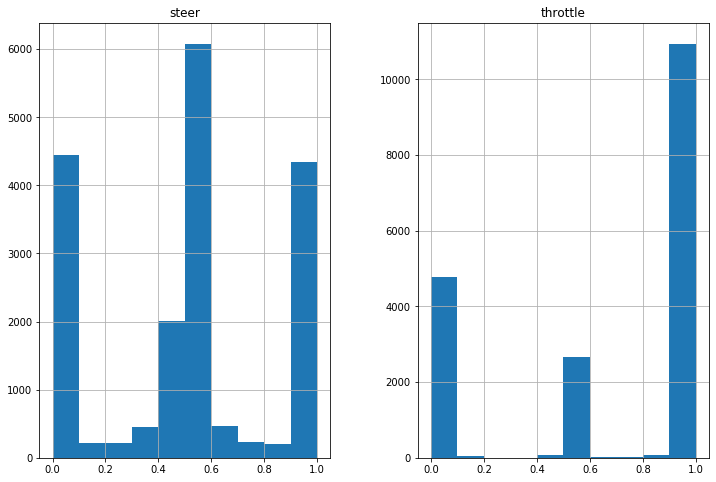

In [36]:
y.hist(figsize=(12, 8))

In [37]:
x_nulls = X.isnull().any()
x_nulls[x_nulls == True]

Series([], dtype: bool)

In [38]:
X_train.describe()

,boost,active,vel_x,vel_y,vel_z,jump_active,dodge_active,ball_dist,angle_to_face_ball,angle_to_move_to_ball,opposing_goal_x,opposing_goal_y,opposing_goal_z,pos_x,pos_y,pos_z,vel_x_op1,vel_y_op1,vel_z_op1,vel_x_ball,vel_y_ball,vel_z_ball,pos_z_ball,map,team
count,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.000000,11192.0,11192.0
mean,0.179133,0.992852,0.514095,0.517863,0.336460,0.007684,0.040207,0.294042,0.473829,0.501707,0.499031,0.586385,0.970148,0.609179,0.470901,0.450485,0.497912,0.503113,0.497925,0.505074,0.647361,0.503786,0.132504,0.2,0.0
std,0.262759,0.084247,0.156685,0.232019,0.063093,0.087325,0.196454,0.188489,0.165125,0.171311,0.203478,0.279015,0.103440,0.144386,0.212090,0.145655,0.155736,0.137573,0.077302,0.129064,0.129441,0.110628,0.208116,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.0
25%,0.000000,1.000000,0.443122,0.360652,0.319346,0.000000,0.000000,0.135020,0.383502,0.408620,0.395138,0.368487,0.997652,0.536347,0.337703,0.485444,0.421814,0.459559,0.476777,0.445256,0.559529,0.452374,0.003150,0.2,0.0
50%,0.050980,1.000000,0.509611,0.500033,0.319384,0.000000,0.000000,0.267432,0.493328,0.522832,0.502369,0.645236,0.998604,0.614550,0.412422,0.492111,0.500634,0.524652,0.514836,0.508596,0.677471,0.514944,0.025675,0.2,0.0
75%,0.333333,1.000000,0.590620,0.680793,0.325840,0.000000,0.000000,0.428838,0.538733,0.553152,0.599055,0.827822,0.998610,0.674856,0.525194,0.499429,0.582605,0.576408,0.515061,0.568144,0.724387,0.534921,0.177019,0.2,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.2,0.0


## Model

In [64]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D

inputs = Input(shape=X_train.shape[1])

x = Dense(1600, activation='relu')(inputs)

x = Dense(800, activation='relu')(x)
x = Dense(400, activation='relu')(x)
x = Dense(200, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(25, activation='relu')(x)
x = Dense(10, activation='relu')(x)

outputs = Dense(y.shape[1], activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name='BittyBot')

model.summary()

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
# losses to try: binary_crossentropy, categorical_crossentropy, mean_squared_error, poisson, mean_squared_logarithmic_error, mean_absolute_error
loss = 'mean_absolute_error'
metrics = ['accuracy']
batch_size = 32
epochs = 2
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "BittyBot"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1600)              41600     
_________________________________________________________________
dense_28 (Dense)             (None, 800)               1280800   
_________________________________________________________________
dense_29 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_30 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_31 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_32 (Dense)             (None, 50)                505

In [76]:
x_nulls = X.isnull().any()
print(x_nulls[x_nulls == True])
y_nulls = y.isnull().any()
print(y_nulls[y_nulls == True])
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)

def train(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=25):
    X_train, y_train, X_val, y_val = np.asarray(X_train), np.asarray(y_train), np.asarray(X_val), np.asarray(y_val)
    start = timer()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    end = timer()
    print(f"The model took {end - start}s to train.")
    
train(model, X_train, y_train, X_val, y_val, batch_size, epochs)

Series([], dtype: bool)
Series([], dtype: bool)
Train on 11192 samples, validate on 3730 samples
Epoch 1/2
11192/11192 [==============================] - 1s 113us/sample - loss: 0.1585 - accuracy: 0.7662 - val_loss: 0.2033 - val_accuracy: 0.7332
Epoch 2/2
11192/11192 [==============================] - 1s 112us/sample - loss: 0.1551 - accuracy: 0.7643 - val_loss: 0.2014 - val_accuracy: 0.7818
The model took 2.5656081809997886s to train.


## Loss and Accuracy

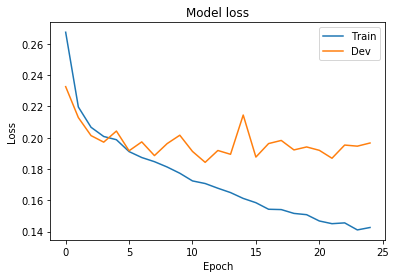

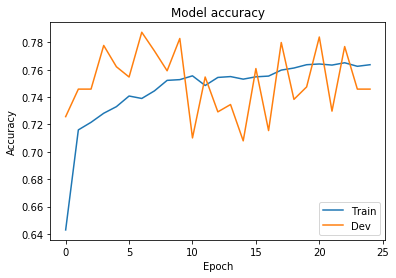

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='best')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='best')
plt.show()

In [56]:
y_pred = model.predict(np.asarray(X_val))
print(y_pred.shape)

<class 'pandas.core.frame.DataFrame'>
(3730, 2)


In [45]:
first_row = X_val.iloc[0]
print(first_row.shape)
print(type(first_row))
arr = np.ndarray((1, first_row.shape[0]), buffer=np.array(first_row))
print(arr)
print(arr.shape)
output = model.predict(arr)

(25,)
<class 'pandas.core.series.Series'>
[[0.33333333 1.         0.53351965 0.48873392 0.39095541 0.
  0.         0.50587112 0.5052159  0.46332848 0.53199596 0.832034
  0.9822561  0.61454982 0.87781392 0.14370631 0.47872265 0.57942014
  0.40776553 0.49794134 0.67747056 0.45485857 0.00223771 0.2
  0.        ]]
(1, 25)


In [46]:
try:
  print(output.flatten()[1])
except IndexError as e:
  pass

1.2464553e-05


In [47]:
X_val.head(1)

,boost,active,vel_x,vel_y,vel_z,jump_active,dodge_active,ball_dist,angle_to_face_ball,angle_to_move_to_ball,opposing_goal_x,opposing_goal_y,opposing_goal_z,pos_x,pos_y,pos_z,vel_x_op1,vel_y_op1,vel_z_op1,vel_x_ball,vel_y_ball,vel_z_ball,pos_z_ball,map,team
2,0.333333,1.0,0.53352,0.488734,0.390955,0.0,0.0,0.505871,0.505216,0.463328,0.531996,0.832034,0.982256,0.61455,0.877814,0.143706,0.478723,0.57942,0.407766,0.497941,0.677471,0.454859,0.002238,0.2,0


In [58]:
one_prediction = model.predict(np.asarray(X_test.head(1)))

def get_value_dict(y, value):
  return dict(zip(y.columns, value))

initial_values = get_value_dict(y, one_prediction[0])
initial_values


{'steer': 0.49261183, 'throttle': 0.9999801}

In [49]:
predictions = pd.DataFrame(y_pred)
predictions.columns = get_y_pred_columns()
predictions.describe()

,steer,throttle
count,3730.000000,3730.000000
mean,0.561339,0.690913
std,0.282373,0.430664
min,0.000007,0.000000
25%,0.441057,0.098527
50%,0.501047,0.999678
75%,0.771660,0.999976
max,0.999947,1.000000


## Prediction Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff73d7df390>,
      dtype=object)

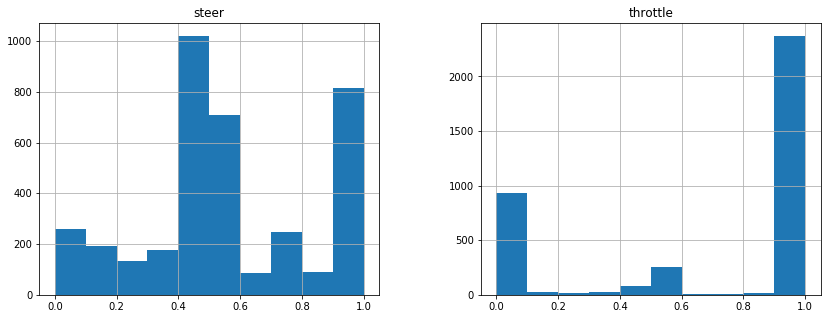

In [50]:
def interpret_result(result):
  final_values = result.copy()
  # for action in ['handbrake', 'boost_active', 'dodge_active', 'double_jump_active', 'jump_active']:
  #   final_values[action] = 1 if initial_values[action] >= 0.5 else 0
  return final_values


# m_val = y_pred.shape[0]
# start = 700
# to_show = 50
# for i in range(start, start + to_show): #m_val):
#   result = y_pred[i]
#   prediction = interpret_result(get_value_dict(y_val, y_pred[i]))
#   print('Predict:', prediction)
#   actual = interpret_result(get_value_dict(y_val, y_val.iloc[i]))
#   print('Actual: ', actual)
#   print('--')

output_df = pd.DataFrame(y_pred)
output_df.columns = y.columns[0:y_pred.shape[1]]
output_df.hist(figsize=(14, 5))

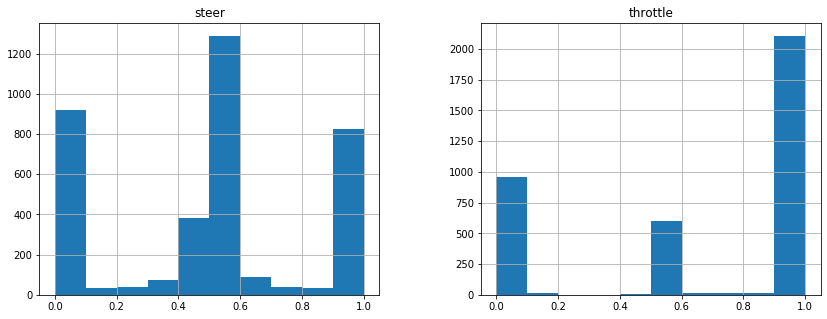

In [51]:
y_val.hist(figsize=(14, 5));

In [52]:
model.save('model_relative.h5')

# @TODO Make this work on Windows.
# !mkdir -p frankenbot/saved_model_relative/
# classifier.save('frankenbot/saved_model_relative/1')

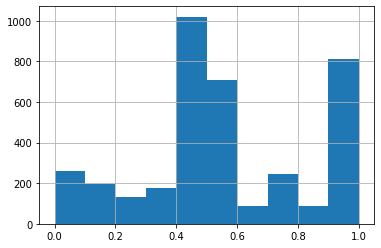

In [53]:
output_df['steer'].hist()

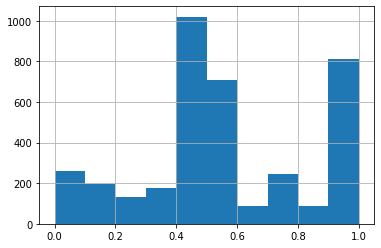

In [54]:
def round_outliers(value):
    if value < 0: return 0
    if value > 1: return 1
    return value

output_df['steer'].apply(round_outliers).hist()